In [1]:
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import pandas as pd

import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
import bt_tools as bt

In [2]:
def non_linear_model_bde(var, a, b, c):
    Z1, Z2 = var.T
    bde = a**2 - b**2*Z1*Z2 +c**2*(Z1**(7/3)+Z2**(7/3))
    return(bde)

In [3]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
data_2 = data.loc[(data['Z1'] >= 5) & (data['Z2'] >= 5) & (data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 13) & (data['Z2'] >= 13) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 31) & (data['Z2'] >= 31) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4]:
    d['unit'] = 630
    #d['bfe type'] = 'homo'
    #d['nbfe'] = np.array(d['Z1'])*np.array(d['Z2'])-(np.array(d['Z1'])+np.array(d['Z2']))

### SRL

In [4]:
# do linear fits
b2 = bt.BDE_clean.fromdict(data_2)
b3 = bt.BDE_clean.fromdict(data_3)
b4 = bt.BDE_clean.fromdict(data_4)
for b in [b2, b3, b4]:
    b.linear_fit()
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

MAE = 3.76 (0.1)
MAE = 0.59 (0.03)
MAE = 0.67 (0.05)


In [5]:
(3.76+0.59+0.67)/3

1.6733333333333331

### SRL*

In [6]:
# non-linear fits

def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    ebfe = -a**2 - b**2*Z1*Z2 -c**2*(Z1**(7/3)+Z2**(7/3))#(-beta*(Z1**(7/3)+Z2**(7/3))+alpha-b_prime*Z1*Z2)
    return(ebfe)

# do linear fits
b2_nl = bt.BDE_clean.fromdict(data_2)
b3_nl = bt.BDE_clean.fromdict(data_3)
b4_nl = bt.BDE_clean.fromdict(data_4)

for b in [b2_nl, b3_nl, b4_nl]:
    b.fit(non_linear_model)
    #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

MAE = 5.86 (0.15)
MAE = 5.94 (0.34)
MAE = 3.57 (0.28)


In [7]:
(5.86+5.94+3.57)/3

5.123333333333334

### Pauling

In [8]:
chi = {'H':2.1, 'Li':1.0, 'B':2.0, 'C':2.5, 'N':3.0, 'O':3.5, 'F':4.0, 
       'Al':1.5, 'Si':1.8, 'P':2.1, 'S':2.5, 'Cl':3.0,
       'Ga':1.6, 'Ge':1.8, 'As':2.0, 'Se':2.4, 'Br':2.8, 'I':2.5}

Z2el = {5:'B', 6:'C', 7:'N', 8:'O', 9:'F', 13:'Al', 14:'Si', 15:'P', 16:'S', 17:'Cl', 31:'Ga', 32:'Ge', 33:'As', 34:'Se', 35:'Br'}

def pauling_model(data):
    energies_pauling = []
    for ZA, ZB in zip(data['Z1'],data['Z2']):

        # get energy ZAZA and ZBZB
        E_AA = -data.loc[(data['Z1']==ZA) & (data['Z2']==ZA), 'bfe'].item()*630
        E_BB = -data.loc[(data['Z1']==ZB) & (data['Z2']==ZB), 'bfe'].item()*630
        # get chi_A, B
        el_A = Z2el[ZA]
        el_B = Z2el[ZB]

        chi_A = chi[el_A]
        chi_B = chi[el_B]
        # calculate bond energy
        E_AB = (E_AA + E_BB)/2 + 23*(chi_A - chi_B)**2
        energies_pauling.append(E_AB)
    energies_pauling = np.array(energies_pauling)
    return(energies_pauling)

def get_error(pred, ref, digits=2):
    MAE = np.round(np.abs(pred-ref).mean(), digits)
    MAE_std = np.round(np.abs(pred-ref).mean()/ref.std(), digits)
    return(MAE, MAE_std)

pauling_2 = pauling_model(pd.DataFrame(data_2))
MAE_2, MAE_std_2 = get_error(pauling_2, b2_nl.bde, digits=2)
print(f'MAE = {MAE_2} ({MAE_std_2})')

pauling_3 = pauling_model(pd.DataFrame(data_3))
MAE_3, MAE_std_3 = get_error(pauling_3, b3_nl.bde, digits=2)
print(f'MAE = {MAE_3} ({MAE_std_3})')

pauling_4 = pauling_model(pd.DataFrame(data_4))
MAE_4, MAE_std_4 = get_error(pauling_4, b4_nl.bde, digits=2)
print(f'MAE = {MAE_4} ({MAE_std_4})')

MAE = 5.13 (0.13)
MAE = 2.94 (0.17)
MAE = 1.66 (0.13)


In [9]:
(5.13+2.94+1.66)/3

3.2433333333333336

In [10]:
### redundant figure

def ref_bde_redundant(data, Z):
    """
    Z: list of nuclear charges
    data: pandas dataframe with bde's
    """
    Z_dict = dict()
    for ZA in Z:
        bde = []
        for ZB in Z:
            if ZA <= ZB:
                bfe = data.loc[(data['Z1']==ZA) & (data['Z2']==ZB), 'bfe'].item()
            else:
                bfe = data.loc[(data['Z1']==ZB) & (data['Z2']==ZA), 'bfe'].item()        
            bde.append(-630*bfe)
        Z_dict[ZA] = [Z ,bde]
    return(Z_dict)

def linear_bde_redundant(bt_model):
    Z = list(set(bt_model.Z1))
    Z = sorted(Z)

    Z_dict = dict()
    for ZA in Z:
        bde = []
        for ZB in Z:
            nA = bt_model.linear_params[Z.index(ZA)]
            nB = bt_model.linear_params[Z.index(ZB)]

            mA = bt_model.linear_params[Z.index(ZA)+len(Z)]
            mB = bt_model.linear_params[Z.index(ZB)+len(Z)]
            
            ebfe = nA + mA*ZB + nB + mB*ZA
            
            # get index of nbfe entry
            # ask where xdata == ZA, ZB and sum up the bool return
            # must be equal to 2
            try:
                nbfe_index = np.where(np.sum(bt_model.xdata == [ZA,ZB], axis = 1) == 2)[0][0]
            except IndexError:
                nbfe_index = np.where(np.sum(bt_model.xdata == [ZB, ZA], axis = 1) == 2)[0][0]
            nbfe = bt_model.nbfe[nbfe_index]
            
            bfe = ebfe + nbfe
            bde.append(-bfe)
            
        Z_dict[ZA] = [Z ,bde]
    return(Z_dict)

def nonlinear_bde_redundant(bt_model):
    Z = list(set(bt_model.Z1))
    Z = sorted(Z)

    Z_dict = dict()
    for ZA in Z:
        bde = []
        for ZB in Z:
            var = np.array([ZA, ZB])
            ebfe = non_linear_model(var, *bt_model.params[0])
            
            # get index of nbfe entry
            # ask where xdata == ZA, ZB and sum up the bool return
            # must be equal to 2
            try:
                nbfe_index = np.where(np.sum(bt_model.xdata == [ZA,ZB], axis = 1) == 2)[0][0]
            except IndexError:
                nbfe_index = np.where(np.sum(bt_model.xdata == [ZB, ZA], axis = 1) == 2)[0][0]
            nbfe = bt_model.nbfe[nbfe_index]
            
            bfe = ebfe + nbfe
            bde.append(-bfe)
            
        Z_dict[ZA] = [Z ,bde]
    return(Z_dict)

def pauling_model_redundant(data, Z):
    Z_dict = dict()
    for ZA in Z:
        bde = []
        for ZB in Z:
            # get energy ZAZA and ZBZB
            E_AA = -data.loc[(data['Z1']==ZA) & (data['Z2']==ZA), 'bfe'].item()*630
            E_BB = -data.loc[(data['Z1']==ZB) & (data['Z2']==ZB), 'bfe'].item()*630
            # get chi_A, B
            el_A = Z2el[ZA]
            el_B = Z2el[ZB]

            chi_A = chi[el_A]
            chi_B = chi[el_B]
            # calculate bond energy
            E_AB = (E_AA + E_BB)/2 + 23*(chi_A - chi_B)**2
            bde.append(E_AB)
            
        Z_dict[ZA] = [Z ,bde]
    return(Z_dict)

def deri_non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    bde = (b**2-630)*Z1 + 7/3*c**2*Z2**(4/3)
    return(bde)   

def nonlinear_derivative(bt_model):
    Z = list(set(bt_model.Z1))
    Z = sorted(Z)

    Z_dict = dict()
    for ZA in Z:
        bde = []
        for ZB in Z:
            var = np.array([ZA, ZB])
            bde.append(deri_non_linear_model(var, *bt_model.params[0]))
            
        Z_dict[ZA] = [Z ,bde]
    return(Z_dict)

 

In [11]:
def test_bde(var, a, b, c):
    Z1, Z2 = var.T
    bde = a - b*Z1*Z2 + c*(Z1**(7/3)+Z2**(7/3))
    return(bde)

In [12]:
sd = 4
params = []
for bt_model in [b2_nl, b3_nl, b4_nl]:
    var = bt_model.xdata
    a, b, c = np.round(bt_model.params[0]**2, sd)
    b = 630 - b
    print((np.abs(test_bde(var, a, b, c) - bt_model.bde)).mean())
    
    params.append([a,b,c])

5.862524533541517
5.932985420907894
3.553115493814344


In [13]:
for n, p in zip([2,3,4], params):
    print(f'{n} & {p[0]} & {p[1]} & {p[2]} \\\\')

2 & 227.7548 & 12.089799999999968 & 2.3403 \\
3 & 271.1576 & 6.475000000000023 & 1.1266 \\
4 & 826.6759 & 4.685600000000022 & 0.6205 \\


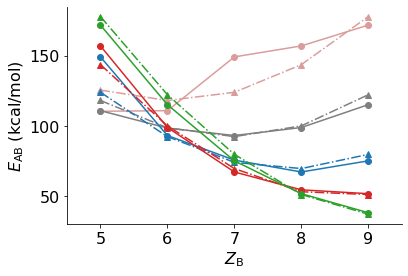

In [14]:
row = 2


if row == 2:
    Z = [5,6,7,8,9]
    b_linear = b2
    b_nl = b2_nl
    color = ['#db9c9cff','#7f7f7fff', '#1f77b4ff', '#d62728ff', '#2ca02cff']
elif row == 3:
    Z = [13, 14, 15, 16, 17]
    b_linear = b3
    b_nl = b3_nl
    color = ['#bba2a2ff', '#ecbe90ff', '#df770eff', '#d5d528ff', '#1ca01cff']
elif row == 4:
    Z = [31, 32, 33, 34, 35]
    b_linear = b4
    b_nl = b4_nl
    color = ['#cc9797ff', '#567676ff', '#a977c8ff', '#f4a51dff', '#942a2aff']
    
    
Z_dict_ref = ref_bde_redundant(data, Z)
Z_dict_linear = linear_bde_redundant(b_linear)
Z_dict_nonlinear = nonlinear_bde_redundant(b_nl)
Z_dict_nonlinear_pauling = pauling_model_redundant(data, Z)

derivative = nonlinear_derivative(b_nl)


#color = ['#ecbe90ff', 'tab:gray', 'tab:blue', 'tab:red', 'tab:green']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)
for ZA, c in zip(Z, color):
    ax.plot(Z_dict_ref[ZA][0], Z_dict_ref[ZA][1], '-o', label = f'ZA = {ZA}', color = c)
    #ax.plot(Z_dict_linear[ZA][0], Z_dict_linear[ZA][1], '--v', color = c)
    ax.plot(Z_dict_nonlinear[ZA][0], Z_dict_nonlinear[ZA][1], '-.^', color = c)
    #ax.plot(Z_dict_nonlinear_pauling[ZA][0], Z_dict_nonlinear_pauling[ZA][1], '--s', color = c)
    
ax.set_xlabel(r'$Z_{\rm{B}}$')
ax.set_ylabel(r'$E_{\rm{AB}}$ (kcal/mol)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([min(Z)-0.5, max(Z)+0.5])

plt.savefig(f'/home/sahre/work/bonding_trends/figures/results/row{row}_red.svg', bbox_inches = 'tight')

(4.5, 9.5)

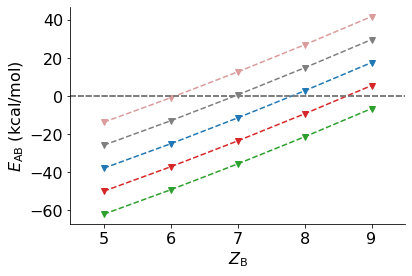

In [15]:
row = 2

if row == 2:
    Z = [5,6,7,8,9]
    b_linear = b2
    b_nl = b2_nl
    color = ['#db9c9cff','#7f7f7fff', '#1f77b4ff', '#d62728ff', '#2ca02cff']
elif row == 3:
    Z = [13, 14, 15, 16, 17]
    b_linear = b3
    b_nl = b3_nl
    color = ['#bba2a2ff', '#ecbe90ff', '#df770eff', '#d5d528ff', '#1ca01cff']
elif row == 4:
    Z = [31, 32, 33, 34, 35]
    b_linear = b4
    b_nl = b4_nl
    color = ['#cc9797ff', '#567676ff', '#a977c8ff', '#f4a51dff', '#942a2aff']
    
Z_dict_ref = ref_bde_redundant(data, Z)

Z_dict_deri_nl = nonlinear_derivative(b_nl)
Z_dict_deri_ref = dict()

for k in Z:
    deri_x = []
    deri_y = []
    for i in range(len(Z_dict_ref[k][0])-1):
        deri_x.append( (Z_dict_ref[k][0][i]+ Z_dict_ref[k][0][i+1])/2 )
        deri_y.append(  (Z_dict_ref[k][1][i+1] - Z_dict_ref[k][1][i] ) / (Z_dict_ref[k][0][i+1] - Z_dict_ref[k][0][i]) )
    Z_dict_deri_ref[k] = [deri_x, deri_y]
    
for k in Z:
    deri_x = []
    deri_y = []
    for i in range(1, len(Z_dict_ref[k][0])-1):
        deri_x.append(Z_dict_ref[k][0][i])
        deri_y.append(  (Z_dict_ref[k][1][i+1] - Z_dict_ref[k][1][i-1] ) / (Z_dict_ref[k][0][i+1] - Z_dict_ref[k][0][i-1]) )
    Z_dict_deri_ref[k] = [deri_x, deri_y]


#color = ['#ecbe90ff', 'tab:gray', 'tab:blue', 'tab:red', 'tab:green']
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1,1)
for ZA, c in zip(Z, color):

    
    ax.plot([min(Z)-0.5, max(Z)+0.5], [0,0], '--', color = 'tab:gray')
    
    #ax.plot(Z_dict_deri_ref[ZA][0], Z_dict_deri_ref[ZA][1], '-o', color = c)
    ax.plot(Z_dict_deri_nl[ZA][0], Z_dict_deri_nl[ZA][1], '--v', color = c)
    
ax.set_xlabel(r'$Z_{\rm{B}}$')
ax.set_ylabel(r'$E_{\rm{AB}}$ (kcal/mol)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([min(Z)-0.5, max(Z)+0.5])

#plt.savefig(f'/home/sahre/work/bonding_trends/figures/results/row{row}_red_deri_nl.svg', bbox_inches = 'tight')

In [21]:
Z_dict_deri_nl

{5.0: [[5.0, 6.0, 7.0, 8.0, 9.0],
  [-13.761621249721664,
   -0.9136858154036958,
   12.671162293374778,
   26.920494240866518,
   41.777441654464866]],
 6.0: [[5.0, 6.0, 7.0, 8.0, 9.0],
  [-25.851437574867425,
   -13.003502140549458,
   0.5813459682290159,
   14.830677915720756,
   29.687625329319104]],
 7.0: [[5.0, 6.0, 7.0, 8.0, 9.0],
  [-37.94125390001319,
   -25.09331846569522,
   -11.508470356916746,
   2.740861590574994,
   17.597809004173342]],
 8.0: [[5.0, 6.0, 7.0, 8.0, 9.0],
  [-50.03107022515895,
   -37.18313479084098,
   -23.598286682062508,
   -9.348954734570768,
   5.507992679027581]],
 9.0: [[5.0, 6.0, 7.0, 8.0, 9.0],
  [-62.12088655030471,
   -49.27295111598674,
   -35.68810300720827,
   -21.43877105971653,
   -6.581823646118181]]}

In [16]:
deri_y

[-48.40559309473285, -31.745648264666638, -18.504666777566026]

In [17]:
import pandas as pd
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
data_2 = data.loc[(data['Z1'] <= 9) & (data['Z2'] <= 9)].to_dict('list')


In [18]:
-630*np.array(data_2['bfe'])

array([ 98.49528829,  93.20659964,  98.91705917, 115.21436085,
        75.66071618,  67.20964411,  75.14743054,  54.47427191,
        51.72306432,  38.13809699, 110.49385254, 110.93407811,
       149.27676277, 157.11721558, 171.95861673])

In [ ]:
# row 2
Z1 = [5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9]
Z2 = [5, 6, 7 ,8 , 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]
xdata = np.array([Z1, Z2]).T
bde = 0.24*np.array([431.6, 426.8, 583.3, 626, 705.4, 359.2, 337.7, 370.2, 452, 259.6, 253.5, 283.6, 195.2, 194.9, 151.7])

#bde = np.array([110.49385254, 110.93407811, 149.27676277, 157.11721558, 171.95861673,  98.49528829,  93.20659964,  98.91705917, 115.21436085, 75.66071618,  67.20964411,  75.14743054,  54.47427191,51.72306432,  38.13809699])

bde_homo = bde[[0, 5, 9, 12, 14]]#np.array([103.584, 86.208,  62.304, 46.848, 36.408])

elements = ['B', 'C', 'N', 'O', 'F']
bde_homo = dict(zip(elements, bde_homo))

In [ ]:
# row 3
Z1 = [13, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 17]
Z2 = [13, 14, 15, 16, 17, 14, 15, 16, 17, 15, 16, 17, 16, 17, 17]
xdata = np.array([Z1, Z2]).T
#bde = 0.24*np.array([257.9, 289.4, 294.5, 402.5, 502.5, 313.2, 287.3, 357.4, 448.4, 225.8, 263.7, 315.1, 252, 258.3, 234.6])

bde_pbe = np.array([ 59.79920224,  69.86379766,  73.47519514,  98.90234845,
       121.12181215, 77.25620984,  74.02914862,  90.49612881, 110.73043846,
        62.75882065,  71.1649616 ,  82.8305566 ,  70.27237772,
        69.51302798,  62.47957441])

bde_homo = bde[[0, 5, 9, 12, 14]]
elements = ['Al', 'Si', 'P', 'S', 'Cl']

bde_homo = dict(zip(elements, bde_homo))

In [ ]:
# row 4
Z1 = [31.0, 31.0, 31.0, 31.0, 31.0, 32, 32, 32, 32, 33, 33, 33, 34, 34, 35]
Z2 = [31.0, 32.0, 33.0, 34.0, 35.0, 32, 33, 34, 35, 33, 34, 35, 34, 35, 35]
xdata = np.array([Z1, Z2]).T

bde = np.array([65.14864892, 69.02427881, 66.26409022, 85.56362194, 99.50397576,72.21042554, 64.45730305, 74.92547657, 88.99081342, 53.84647516,
       59.52618602, 68.87128326, 59.71296505, 59.3387519 , 54.46767659])

bde_homo = bde[[0, 5, 9, 12, 14]]
elements = ['Ga', 'Ge', 'As', 'Se', 'Br']

bde_homo = dict(zip(elements, bde_homo))

In [ ]:
plt.plot(bde)

In [ ]:
a = np.sqrt(215)
b = -np.sqrt(10)
c = np.sqrt(2)

af, bf, cf = curve_fit(non_linear_model_bde, xdata, ydata=bde, p0=[a,b,c])[0]

In [ ]:
mae = np.abs(bde-non_linear_model_bde(xdata, af, bf, cf)).mean()

In [ ]:
np.abs(bde[5:]-non_linear_model_bde(xdata, af, bf, cf)[5:]).mean()

In [ ]:
# Pauling
chi = {'H':2.1, 'Li':1.0, 'B':2,'C':2.5, 'N':3.0, 'O':3.5, 'F':4.0, 
       'Al':1.5, 'Si':1.8, 'P':2.1, 'S':2.5, 'Cl':3.0,
       'Ga':1.6, 'Ge':1.8, 'As':2.0, 'Se':2.4, 'Br':2.8}

bde_pauling = []
for i in range(5):
    for j in range(i, 5):
        el_A = elements[i]
        el_B = elements[j]
        
        chi_A = chi[el_A]
        chi_B = chi[el_B]
        E_AA = bde_homo[el_A]
        E_BB = bde_homo[el_B]
        
        E_AB = (E_AA + E_BB)/2 + 23*(chi_A - chi_B)**2
        bde_pauling.append(E_AB)
        
bde_pauling = np.array(bde_pauling)
mae_pauling = np.abs(bde_pauling-bde).mean()

In [ ]:
el_dict = {5:'B', 6:'C', 7:'N', 8:'O', 9:'F', 
           13:'Al', 14:'Si', 15:'P', 16:'S', 17:'Cl',
           31:'Ga', 32:'Ge', 33:'As', 34:'Se', 35:'Br'}

In [ ]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['font.size'] = 14

xlabels = []
for el1, el2 in xdata:
    xlabels.append(el_dict[el1] + el_dict[el2])

plt.plot(xlabels, bde, '-o', label = 'ref')
plt.plot(non_linear_model_bde(xdata, af, bf, cf), '-o', label = f'fit, MAE = {np.round(mae, 1)} kcal/mol')
plt.plot(bde_pauling, '-v', label = f'Pauling, MAE = {np.round(mae_pauling, 1)}')

plt.ylabel('BDE (kcal/mol)')
plt.legend()

In [ ]:
plt.rcParams['figure.figsize'] = [4,4]
plt.rcParams['font.size'] = 18

plt.plot([np.amin(bde), np.amax(bde)], [np.amin(bde), np.amax(bde)], '--', color = 'tab:gray')
plt.plot(bde, non_linear_model_bde(xdata, af, bf, cf), 'o')

plt.xlabel('BDE ref (kcal/mol)')
plt.ylabel('BDE model (kcal/mol)')